# Detecting Climate Change Disinformation on Twitter
Andres De La Fuente

University of Washington, 2021


## Introduction

The idea of this project is to explore a collection of tweets which are about a political topic (Climate Change), and employ specific features related to user accounts in order to potentially identify evidence of astroturfing - specifically, I focus on the presence of bots. Then I analyze whether potential bot accounts post meaningfully different content from others.

## Motivation
People today are exposed to more information than ever before, it has become completely unfeasible for an individual to really evaluate everything they see critically. It has become clear that various forms of manipulative tactics on social media are very effective, as they have been used to influence elections around the world, and more recently to sow distrust in the medical community (COVID-19 disinformation). 

It is necessary for us to start investigating these dynamics and treating the flow of information on the internet as the essential basis of society that it has become. My goal with this project is small relative to this problem, but is along these lines.

## Data
For this analysis, I use the following dataset of tweets about climate change:

[Data](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/5QCCUU)

The data simply contains the IDs of tweets which feature climate change related hashtags such as #climatechange or #climatehoax posted between a span of a couple years.

The license for the dataset is CC0, and is for public use. The terms of service require citation. 
This data fits the project neatly as it provides a set of tweets already selected based on a specific political topic.

One reason for using tweets related to climate change is that I want to focus on a political topic for which what we consider to be disinformation is widely agreed upon. There is such a broad scientific consensus on the reality of man made climate change that I can go into the analysis taking climate change denial as disinformation.

A broad ethical consideration with relation to this type of analysis is the implication of using human generated content to identify intent. It is possible to mischaracterize real user behavior as disingenous organized behavior, and if this is the case the insights might falsely suggest that a particular agenda is purely pushed by artificial activity. That said, the feature of posting frequency I use here is a very strong indication of bots, as is made evident in the analysis.

### How to Set Up the Data Yourself
The referenced dataset contains identifier numbers for the selected tweets. It numbers in the millions of tweets, but I use a subset of that here. The dataset is broken into three separate text files in on the source website, download the first of these files.

Next, you need a tool such as [Twarc](https://github.com/DocNow/twarc), which is what I use, to 'hydrate' the tweets. This means that you are going through Twitter's developer API to reference the tweet identifiers and retrieve all of the information for each tweet. This is returned in JSON format. 

**You need a Twitter Developer account to perform the hydration process**. 

Unfortunately, Twitter's Terms of Service do not allow the public sharing of full tweet information colleted through their API, so I can only share tweet identifiers (this is the reason my referenced dataset is also in this format).

For my analysis, I use a randomly selected subset of 100,000 tweets. To select these tweets I use the following command in a Linux terminal:

```
shuf -n 100000 input_file.txt > output_file.txt
```

Once you have done this, perform the hydration using Twarc on your output_file.txt (however you wish to name it). The resulting JSON file is what you should use as input in 'Loading Data' section below. In my code, this is called "small_tweets.jsonl". I have included my particular sample of 100000 tweet IDs as "small_sample.txt" in the repository.

&nbsp;

*I have included a python script called "tweetID_sampler.py" so you can perform the random sampling of tweet IDs even if you cannot use shuf. The script will prompt you for input and output filenames as well as the number you wish to sample.*


&nbsp;
# Research Questions
- **Are there accounts in this dataset that meaningfully differ from the bulk based on indicators of bot activity?**

- **Are there meaningful differences in tweet content between identified potential bots and the rest?**

- **Do these differences in content suggest a specific agenda for the suspected accounts?**

# Background / Related Work
[Political Astroturfing in South Korea](https://www.researchgate.net/profile/Junghwan_Yang2/publication/317290047_How_to_Manipulate_Social_Media_Analyzing_Political_Astroturfing_Using_Ground_Truth_Data_from_South_Korea/links/59305a9ca6fdcc89e7844440/How-to-Manipulate-Social-Media-Analyzing-Political-Astroturfing-Using-Ground-Truth-Data-from-South-Korea.pdf)

[Russian Political Disinformation](https://secondaryinfektion.org/)

[Detecting the Use of Multiple Accounts](https://onlinelibrary.wiley.com/doi/abs/10.1002/cpe.4013)

[Common Signs of Bots](https://blog.mozilla.org/internetcitizen/2018/01/08/irl-how-to-spot-a-bot/)

The somewhat limited work that exists in this area indicates two different kinds of analyses that are used to identify inorganic activity. First, there is the consideration of individual user features, such as an account's age and posting frequency, which can be useful for identifying bots. Second, when looking for astroturfing, it is necessary to consider trends and patterns in posting activity, finding similarities in content even across platforms. The latter type of analysis is much more involved and technically complicated, so I will focus on the former: user account features.

# Methodology

**Exploratory Visualizations:** 

I use some exploratory visualizations and statistical summaries to explore the user features which I have identified as potential indicators of inorganic activity.

**Clustering Algorithms:** 

Since some of these features turn out to indicate strong distinctions among user accounts, and the suspicious accounts number far fewer than the overall accounts, I use Gaussian Mixture clustering to group accounts based on these features.

**Manual Subset Selection:**

Besides clustering, due to the very interpretable nature of the selected features, I also manually select a subset of accounts by using cutoffs for these features.

**NLP:** 

I use simple string tokenization to calculate things such as the presence of hashtags in the different tweet groupings, as well as the use of URLs. 

I use the Vader sentiment analysis tool from the NLTK python package to get some simple sentiment insights. This tool uses a bag of word approach (it has a reference table of positive and negative words), as well as heuristics to take care of sentiment flipping (the use of 'not' before a word).



In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from collections import Counter

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/oponn/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


&nbsp;
## Helper Functions
Below are helper functions that are used further down through the analyses.

&nbsp;

**percentNumbers**

This calculates the percentage of numerical digits in a string, to be used on screen names of twitter accounts.

In [3]:
def percentNumbers(my_string):
    return (len(re.sub("[^0-9]", "", my_string))/len(my_string))

**listNotEmpty**

This returns True if the given list is empty, to be used for noting the presence of things within a tweet of which there could be more than one (e.g. URLs).

In [4]:
def listNotEmpty(my_list):
    return(len(my_list) > 0)

In [5]:
def containsOrg(url_list):
    contains = False
    for i in url_list:
        if (".org" in i):
            contains = True
    return contains

&nbsp;
## Load and Preview Data
First, I load the data from the json file generated by hydrating the list of tweet ID's through Twitter's API. 

I preview the data in the following cell.

In [6]:
dfs = pd.read_json('small_tweets.jsonl', encoding='utf-8', lines=True)

In [7]:
dfs.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,quoted_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,extended_entities,withheld_in_countries
0,2018-06-13 21:12:26+00:00,1007007810725597184,1007007810725597184,So concerned for our earth while others just w...,False,"[0, 160]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,{'created_at': 'Wed Jun 13 19:07:30 +0000 2018...,0,0,False,False,0.0,en,NaN,NaN,NaN
1,2018-06-16 22:12:00+00:00,1008109966232875009,1008109966232875008,"""Poor people just get the short end of the sti...",False,"[0, 223]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://about.twitter.com/products/tw...",NaN,NaN,...,NaN,1,3,False,False,0.0,en,NaN,NaN,NaN
2,2018-06-21 14:12:17+00:00,1009801182317932544,1009801182317932544,"Even during all of this chaos, these assholes ...",False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://tapbots.com/tweetbot"" rel=""nof...",NaN,NaN,...,{'created_at': 'Thu Jun 21 13:55:07 +0000 2018...,0,1,False,False,0.0,en,NaN,NaN,NaN
3,2018-06-22 01:49:22+00:00,1009976609154088961,1009976609154088960,RT @MikeHudema: These Indigenous defenders are...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",NaN,NaN,...,NaN,235,0,False,False,0.0,en,{'created_at': 'Thu Jun 21 20:44:01 +0000 2018...,NaN,NaN
4,2018-06-22 15:17:38+00:00,1010180016418590720,1010180016418590720,RT @eugenegu: Trump’s Red Wave is another term...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,NaN,4023,0,False,False,NaN,en,{'created_at': 'Fri Jun 22 12:09:41 +0000 2018...,NaN,NaN


&nbsp;
## Account Feature Exploration
In the following section, I calculate and explore various features related to user accounts which can be indicative of inorganic activity. The selection of these features to focus on is based on the works referenced in the 'Background' section above. The features I look into are:
- Account Age (at the time of posting the tweet)
- Bio Length
- Posting Frequency (posts made per day)
- Percentage of Numbers in Name (screen name, or 'handle')

&nbsp;
### Account Age Calculations
One of the most common identifying features of inorganic activity is relatively young accounts. When batches of accounts are made for bot use or human astroturfing, the accounts are typically used right away, rather than letting them age for years before use. As can be observed below, most user accounts are years old.

&nbsp;

**Isolate account creation dates**

First I get a list of the timestamps for account creation related to each tweet.

In [8]:
acct_start = []

for i in dfs['user']:
    acct_start.append(i['created_at'])   

**Calculate age of account when posting each tweet**

Now, I record the difference between the tweet's creation time and associated account's creation time for each tweet.

In [9]:
age_at_post = []

for i in range(len(acct_start)):
    # Get the account creation date and post date
    a = acct_start[i]
    b = dfs['created_at'][i]
    
    # Convert both into the same Timestamp format
    a = pd.Timestamp(a).tz_localize(None)
    b = pd.Timestamp(b).tz_localize(None)
    
    # Calculate the age at posting in seconds
    age_at_post.append((b - a).total_seconds())
    

**Convert to days**

I convert the account age at time of posting from seconds to days.

In [10]:
seconds_in_day = 60 * 60 * 24
age_at_post_days = [x / seconds_in_day for x in age_at_post]

&nbsp;
### Visualizing Account Ages
Below I visualize the spread of account ages at time of posting. I also display some summary statistics in the following cell. As expected, the distribution implies that the accounts have been created throughout the existence of Twitter, with the average age being a few years.

Text(0, 0.5, 'Accounts')

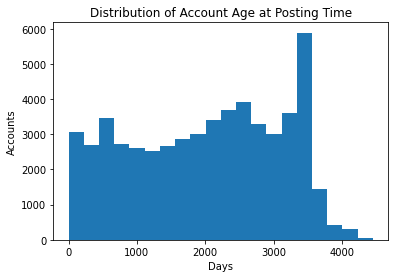

In [11]:
plt.hist(age_at_post_days, bins=20)
plt.title("Distribution of Account Age at Posting Time")
plt.xlabel("Days")
plt.ylabel("Accounts")

In [12]:
stats.describe(age_at_post_days)

DescribeResult(nobs=54606, minmax=(0.001388888888888889, 4451.296400462963), mean=2006.903889598094, variance=1220622.339959223, skewness=-0.16379952022070168, kurtosis=-1.1726402652229686)

In [13]:
dfs["user"][0]

{'id': 1674050738,
 'id_str': '1674050738',
 'name': 'Catherine Maron',
 'screen_name': 'CCmmaron',
 'location': '',
 'description': 'Proud mom of 3, grateful daughter and partner, teacher and life-long learner.',
 'url': None,
 'entities': {'description': {'urls': []}},
 'protected': False,
 'followers_count': 20,
 'friends_count': 143,
 'listed_count': 0,
 'created_at': 'Thu Aug 15 20:56:49 +0000 2013',
 'favourites_count': 74,
 'utc_offset': None,
 'time_zone': None,
 'geo_enabled': False,
 'verified': False,
 'statuses_count': 67,
 'lang': None,
 'contributors_enabled': False,
 'is_translator': False,
 'is_translation_enabled': False,
 'profile_background_color': 'C0DEED',
 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme1/bg.png',
 'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme1/bg.png',
 'profile_background_tile': False,
 'profile_image_url': 'http://pbs.twimg.com/profile_images/946702944812064769/G9nrKQbU_normal.jpg',
 '

&nbsp;
### Posting Frequency Calculations
Another suspicious account feature which is intuitively a good indicator of inorganic activity is an account's posting frequency. Fake accounts, especially bots, are made with the goal of spreading or magnifying some message, therefore they are used to perform large amounts of activity (such as retweeting, which counts as a tweet) relative to the average human user.

&nbsp;

**Calculate number of posts**

First I calculate the number of posts made by the account associated with each tweet.

In [14]:
num_posts = []
for i in range(len(dfs)):
    num = dfs['user'][i]['statuses_count']
    num_posts.append(num)

As evidenced by some summary statistics, there are posting amounts which are suspiciously high.

In [15]:
stats.describe(num_posts)

DescribeResult(nobs=54606, minmax=(1, 3655420), mean=74751.57246456433, variance=21746165132.687603, skewness=7.0802519805446655, kurtosis=98.92684000569524)

**Caluclate frequency**

Next I calculate the frequency of posts (ratio of total posts versus account age) for the account associated with each tweet.

In [16]:
post_freq = []

for i in range(len(dfs)):
    num_posts = dfs['user'][i]['statuses_count']
    age = age_at_post_days[i]
    frequency = num_posts / age
    post_freq.append(frequency)

&nbsp;
### Visualizing Posting Frequencies
Below I visualize the spread of posting frequencies associated with each tweet's account. I also display some summary statistics in the following cell. 

The resulting distribution indicates some very extreme outliers. Posting frequencies of tens of thousands of tweets per day are a huge red flag, as it is totally unfeasible for a human to perform. The vast majority of posting frequencies fall below the mean of 91 (which is heavily skewed by the outliers).

Text(0, 0.5, 'Accounts')

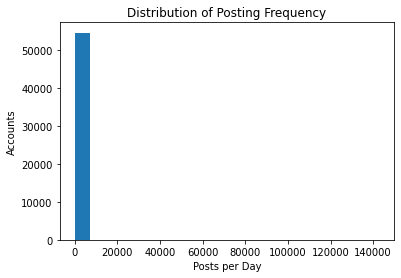

In [17]:
plt.hist(post_freq, bins=20)
plt.title("Distribution of Posting Frequency")
plt.xlabel("Posts per Day")
plt.ylabel("Accounts")

In [18]:
stats.describe(post_freq)

DescribeResult(nobs=54606, minmax=(0.000580973055767449, 142815.7090579847), mean=91.98627413104639, variance=1558403.1677854308, skewness=71.40248719385137, kurtosis=6228.969220544044)

&nbsp;
### Bio Length Calculations
Though less strongly indicative of artificial activity, two features related to the user account information might be indicative of fake accounts. Below I look into the length of bio, or 'description, for the account associated with each tweet.

&nbsp;

**Calculate bio length**

I calculate the length of the 'description' string for the account associated with each tweet.

In [19]:
bio_len = []
for i in range(len(dfs)):
    length = len(dfs['user'][i]['description'])
    bio_len.append(length)

&nbsp;
### Visualizing Bio Lengths
Here I visualize the spread of bio lengths (in characters).  I also display some summary statistics in the following cell.

The distribution appears bimodal, with large numbers of accounts at each end of the length spectrum. As evidenced further down, when I take a look at some sample accounts, the bio length is not as useful of a feature for identifying 'fake' accounts.

Text(0, 0.5, 'Accounts')

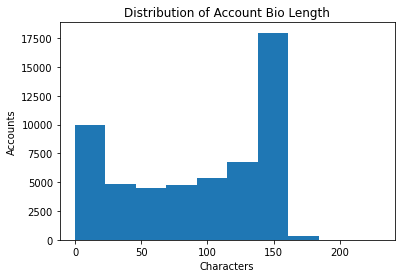

In [20]:
plt.hist(bio_len)
plt.title("Distribution of Account Bio Length")
plt.xlabel("Characters")
plt.ylabel("Accounts")

In [190]:
stats.describe(bio_len)

DescribeResult(nobs=54606, minmax=(0, 230), mean=92.64926931106471, variance=3259.9845216710105, skewness=-0.37553935975398567, kurtosis=-1.3379136618555223)

&nbsp;
### Percent of Numbers in Name Calculations
As a final user account feature to explore, I look at the percentage of numerical digits in an account's screen name, or 'handle'. According to [this Mozilla resource](https://blog.mozilla.org/internetcitizen/2018/01/08/irl-how-to-spot-a-bot/) referenced in the 'Background' section above, account names with a jumble of letters and numbers can be indicative of bots. This makes sense, as creating batches of accounts in some automated fashion would be easier if generating such names.

&nbsp;

**Calculate percentage**

I calculate the percentage of numerical digits (0 through 9) present in the account screen name associated with each tweet. I use a helper function defined above to do this.

In [21]:
num_in_name = []

for i in range(len(dfs)):
    percent_num = percentNumbers(dfs['user'][i]['screen_name'])
    num_in_name.append(percent_num)

&nbsp;
### Visualizing Percent of Numbers in Names
Below I visualize the spread of percentages of numerical digits in accounts' screen names. I also display some summary statistics in the following cell.

Like posting frequency, this is a very skewed distribution. The bulk of accounts have less than 10% numbers in their screen names, yet some accounts go up to more than 50% of their names being numbers.

Text(0, 0.5, 'Accounts')

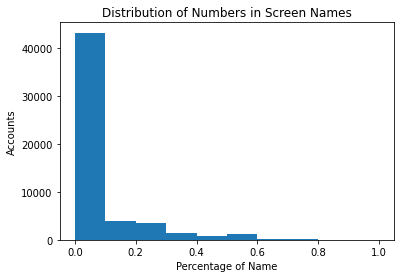

In [22]:
plt.hist(num_in_name)
plt.title("Distribution of Numbers in Screen Names")
plt.xlabel("Percentage of Name")
plt.ylabel("Accounts")

In [23]:
stats.describe(num_in_name)

DescribeResult(nobs=54606, minmax=(0.0, 1.0), mean=0.061592315832234526, variance=0.017366093837537244, skewness=2.5265328610515523, kurtosis=6.561384560140549)

&nbsp;
### Visualizing Tweets Based on Suspect Account Features
Below I plot the tweets according to the 3 of the potentially identifying features for inorganic activity:
- Account Age at Time of Posting
- Percent of Numbers in Name
- Posting Frequency

As can be observed, there are several accounts which are clear stand outs. An interesting observation is that the **bio length** is not really as useful of a differentiator as **posting frequency** and **account age**. **Posting frequency** appears to be the greatest distinguishing factor, and the highest posting frequencies are all for *very* young accounts. This is what would be expected for bot accounts. No human user would reasonably post tens of thousands of tweets within a day of making an account.

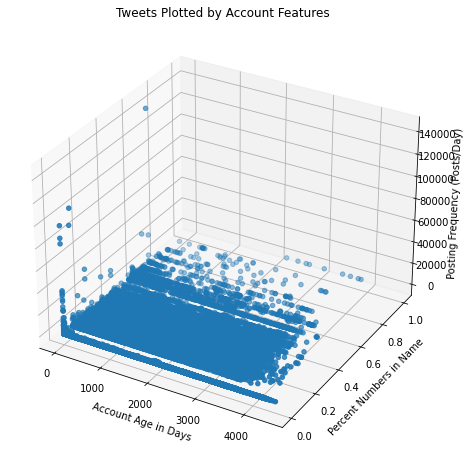

In [24]:
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)
ax.set_title("Tweets Plotted by Account Features")
ax.set_xlabel("Account Age in Days")
ax.set_ylabel("Percent Numbers in Name")
ax.set_zlabel("Posting Frequency (Posts/Day)")
ax.scatter(age_at_post_days, num_in_name, post_freq)

&nbsp;
## Adding Features to the Dataframe
In this section I add both the user features selected above and a couple of feature related to content to the main dataframe. This way, once the clustering is performed on the user features, the dataframe can be separated while already containing the content features that will be needed for analysis.

&nbsp;

**User features columns**

First I add a column for each user feature calculated.

In [25]:
dfs['posting_age'] = age_at_post_days
dfs['num_in_name'] = num_in_name
dfs['posting_frequency'] = post_freq

**Content features columns**

I add a column for the presence of URLs (boolean), and the sentiment (positive and negative) rating in each tweet.

First I use the Vader sentiment analysis tool from the NLTK python package to generate sentiment scores to associate with each tweet. I add these as a column.

In [26]:
# initialize the sentiment analysis tool
sid = SentimentIntensityAnalyzer()

# define lists to contain positive and negative scores for each tweet
pos_score = []
neg_score = []

for i in range(len(dfs)):
    # calculate the scores for this tweet
    scores = sid.polarity_scores(dfs['full_text'][i])
    positive = scores['pos']
    negative = scores['neg']
    
    # add them to the respective lists
    pos_score.append(positive)
    neg_score.append(negative)
    
    

Now I use my helper function to mark the presence of URLs in each tweet.

In [27]:
has_url = []

for i in range(len(dfs)):
    presence = listNotEmpty(dfs['entities'][i]['urls'])
    has_url.append(presence)

**Add content feature columns**

Next I add these three content features (positive rating, negative rating, url presence) as columns to the dataframe.

In [28]:
dfs['pos'] = pos_score
dfs['neg'] = neg_score
dfs['has_url'] = has_url

&nbsp;
## Clustering and Manual Selection
Below I perform simple k means clustering on the selected user features, and I also perform a manual selection using cutoffs for these features. I do this because the nature of what I am trying to isolate (a small percentage of accounts with intuitive and interpretable distinctions in features) does not lend itself to basic clustering where the cluster shape and size is assumed.

Manual selection is acceptable because the features being used are very easily interpretable - it makes intuitive sense to say that a human user would not have a posting frequency of above 1,000 tweets per day, while also having an account a day or two old.

&nbsp;

**Select clustering features**

First I isolate the features being clustered on.

In [69]:
cluster_features = dfs[['posting_age', 'num_in_name', 'posting_frequency']]

**Train a K Means model on the whole dataset**

I show the results of training over the whole dataset simply to ovserve how adequate the method may be for selecting the suspicious accounts. Thankfully the accounts we want to target are clearly visible and justified already so we can evaluate based on this.

The apparent result is that two of our clusters capture the most suspicious data points.

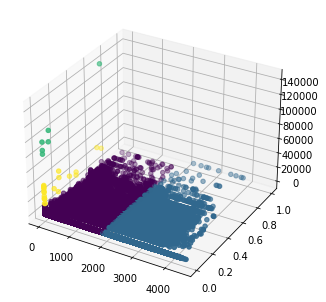

In [73]:
kmeans = KMeans(n_clusters=4).fit(cluster_features)
predictions = kmeans.predict(cluster_features)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(cluster_features['posting_age'], cluster_features['num_in_name'], cluster_features['posting_frequency'], 
            c=predictions)

**Select tweets from the suspicious clusters**

Here I select the 27 tweets which have the most suspicious user account features based on clustering.

In [74]:
dfs['cluster'] = predictions

In [79]:
dfs_select = dfs.loc[(dfs['cluster'] == 3) | (dfs['cluster'] == 2)]

I also select suspicious data points using some manual feature cutoffs based on my own intuitive understanding of these features.

In [80]:
dfs_manual = dfs.loc[(dfs['posting_age'] < 2) | (dfs['posting_frequency'] > 1000)]

&nbsp;
## Hashtag Use Calculation
Below I calculate the last feature I am interested in for analyzing between suspicious accounts and the rest: the use of hashtags. 

In the following two cells, I generate a list of all hashtags used in both the clustering selection and the manual selection of tweets.

In [81]:
dfs_select = dfs_select.reset_index(drop=True)
dfs_manual = dfs_manual.reset_index(drop=True)

In [82]:
hashtags_cluster = []
for i in dfs_select['full_text']:
    for word in i.split():
        if word[0] == '#':
            hashtags_cluster.append(word[1:])

In [83]:
hashtags_manual = []
for i in dfs_manual['full_text']:
    for word in i.split():
        if word[0] == '#':
            hashtags_manual.append(word[1:])

Also create a list for hashtags overall.

In [84]:
hashtags_all = []
for i in dfs['full_text']:
    for word in i.split():
        if word[0] == '#':
            hashtags_all.append(word[1:])

&nbsp;
## Examining the Differences
In this section I compare the content features for the selected suspicious tweets versus the overall tweets.

First I get the hashtag counts for tweets in each grouping.

In [85]:
all_hash_count = Counter(hashtags_all)
cluster_hash_count = Counter(hashtags_cluster)
manual_hash_count = Counter(hashtags_manual)

### Visualizing Hashtag Usage
Below I visualize the top 5 hashtags by the percent they make up of total hashtags in each of the selections.

Text(0, 0.5, 'Percentage of hashtags')

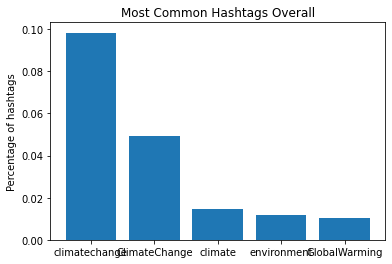

In [86]:
plt.bar([i[0] for i in all_hash_count.most_common(5)], 
        [i[1] / len(hashtags_all) for i in all_hash_count.most_common(5)])
plt.title('Most Common Hashtags Overall')
plt.ylabel('Percentage of hashtags')

Text(0, 0.5, 'Percentage of hashtags')

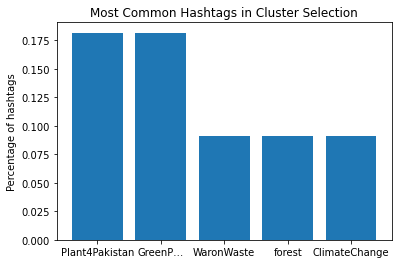

In [87]:
plt.bar([i[0] for i in cluster_hash_count.most_common(5)], 
        [i[1] / len(hashtags_cluster) for i in cluster_hash_count.most_common(5)])
plt.title('Most Common Hashtags in Cluster Selection')
plt.ylabel('Percentage of hashtags')

Text(0, 0.5, 'Percentage of hashtags')

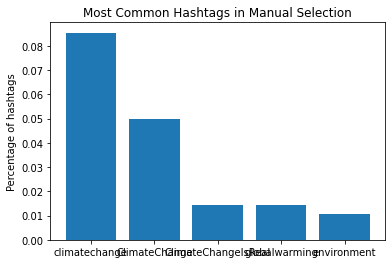

In [88]:
plt.bar([i[0] for i in manual_hash_count.most_common(5)], 
        [i[1] / len(hashtags_manual) for i in manual_hash_count.most_common(5)])
plt.title('Most Common Hashtags in Manual Selection')
plt.ylabel('Percentage of hashtags')

### Use of Hashtags Insights
The tweets selected by clustering show a significant difference in the top 5 used hashtags, though the topics suggested by these do not appear to have a negative tilt towards climate change: the top hashtag "#Plant4Pakistan" refers to a tree planting initiative, and "#WaronWaste" referes to a public initiative to limit trash.

Overall it appears the general use of hashtags is not a sufficient analysis to suggest political astroturfing by the accounts we suspect of being bots.


&nbsp;
### Visualizing URL Use
Below I visualize the use of URLs in each of the selections.

In [89]:
overall_url = dfs['has_url'].value_counts() / len(dfs)
select_url = dfs_select['has_url'].value_counts() / len(dfs_select)
manual_url = dfs_manual['has_url'].value_counts() / len(dfs_manual)

Text(0, 0.5, 'Percentage')

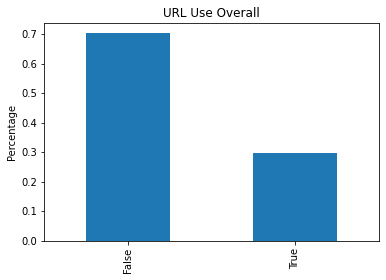

In [90]:
overall_url.plot(kind='bar')
plt.title("URL Use Overall")
plt.ylabel("Percentage")

Text(0, 0.5, 'Percentage')

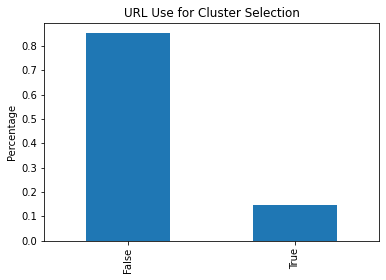

In [91]:
select_url.plot(kind='bar')
plt.title("URL Use for Cluster Selection")
plt.ylabel("Percentage")

Text(0, 0.5, 'Percentage')

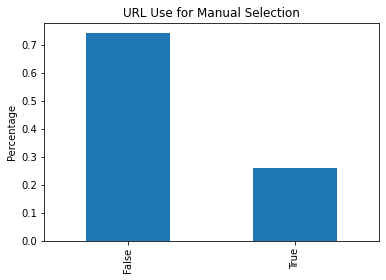

In [92]:
manual_url.plot(kind='bar')
plt.title("URL Use for Manual Selection")
plt.ylabel("Percentage")

### Use of URLs Insights
The tweets selected by clustering show a difference in the percentage of tweets using URLs. Where overall, URLs are used in around 30% of the tweets, they are used in less than 20% of the tweets from suspicious accounts. This could be explained by a high number of retweets - it does not match our intuition from background reading.

This breakdown does suggest a difference in posting activity for the suspected bot accounts versus overall, and the difference lines up with intuitive expecations.

&nbsp;
### Exploring Sentiment
Below I visualize the sentiment breakdown in each grouping.

**Sentiment for Overall**

In [93]:
all_sentiment = dfs[['pos', 'neg']]

In [94]:
print("Positive:")
print(np.mean(all_sentiment['pos']))
print("Negative")
print(np.mean(all_sentiment['neg']))

Positive:
0.08008422151411933
Negative
0.08898069809178479


**Sentiment for Clustered Selection**

In [95]:
cluster_sentiment = dfs_select[['pos', 'neg']]
print("Positive:")
print(np.mean(cluster_sentiment['pos']))
print("Negative:")
print(np.mean(cluster_sentiment['neg']))

Positive:
0.06244444444444445
Negative:
0.10944444444444444


**Sentiment for Manual Selection**

In [96]:
manual_sentiment = dfs_manual[['pos', 'neg']]
print("Positive:")
print(np.mean(manual_sentiment['pos']))
print("Negative:")
print(np.mean(manual_sentiment['neg']))

Positive:
0.08076138828633404
Negative:
0.08218221258134491


In [107]:
dfs_select

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,retweeted_status,extended_entities,withheld_in_countries,posting_age,num_in_name,posting_frequency,pos,neg,has_url,cluster
0,2018-09-12 06:31:06+00:00,1039763314337820672,1039763314337820672,Looking forward to meeting @craigreucassel ton...,False,"[0, 139]","{'hashtags': [{'text': 'WaronWaste', 'indices'...","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",NaN,NaN,...,NaN,"{'media': [{'id': 1039762810459250688, 'id_str...",NaN,0.013160,0.000000,81840.633245,0.000,0.261,False,2
1,2018-08-07 17:15:49+00:00,1026879598481563648,1026879598481563648,"RT @JerryDunleavy: Bill Cosby, Kevin Spacey, a...",False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,{'created_at': 'Mon Aug 06 20:33:50 +0000 2018...,NaN,NaN,3.102407,0.000000,21925.875963,0.000,0.207,False,3
2,2018-09-24 18:53:40+00:00,1044298840684212224,1044298840684212224,RT @mack3636: If she really believes in equali...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",NaN,NaN,...,{'created_at': 'Mon Sep 24 18:45:51 +0000 2018...,NaN,NaN,10.949896,0.000000,21023.396341,0.079,0.000,False,3
3,2018-07-31 13:27:31+00:00,1024285428445138944,1024285428445138944,RT @MoneyFemDom: HeadMistress Cleo &amp; Rinse...,False,"[0, 144]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,{'created_at': 'Mon Jul 30 14:04:58 +0000 2018...,NaN,NaN,0.037118,0.000000,86804.115996,0.000,0.000,True,2
4,2018-07-10 13:07:06+00:00,1016670148407775234,1016670148407775232,".@cathmckenna, women &amp; girls are vulnerabl...",False,"[0, 178]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://www.globalcitizen.org/"" rel=""...",NaN,NaN,...,NaN,NaN,NaN,0.006319,0.363636,17564.835165,0.173,0.061,False,3
5,2018-08-07 01:29:13+00:00,1026641380632715264,1026641380632715264,RT @ajplus: West Hollywood's City Council will...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,{'created_at': 'Mon Aug 06 19:14:50 +0000 2018...,NaN,NaN,0.833854,0.000000,97940.387258,0.000,0.000,False,2
6,2018-08-21 21:15:27+00:00,1032013332591665155,1032013332591665152,"“SIN, NOT CARBON, CAUSES CLIMATE CHANGE.",False,"[0, 40]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",NaN,NaN,...,NaN,NaN,NaN,0.180602,0.000000,36561.086901,0.000,0.000,False,3
7,2018-09-29 13:49:52+00:00,1046034326410809349,1046034326410809344,RT @_cingraham: Incredible story: Trump admini...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,{'created_at': 'Fri Sep 28 13:51:31 +0000 2018...,NaN,NaN,0.955602,0.071429,106740.061044,0.069,0.196,False,2
8,2018-09-02 11:35:04+00:00,1036215932199346176,1036215932199346176,RT @FawadPTIUpdates: Pakistan is one of the 7 ...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,{'created_at': 'Sun Sep 02 08:49:58 +0000 2018...,NaN,NaN,0.011794,0.000000,35102.649657,0.154,0.073,False,3
9,2018-10-09 13:49:57+00:00,1049658227372249093,1049658227372249088,RT @ialhusseini: Help me change the world. For...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,{'created_at': 'Mon Apr 02 18:38:56 +0000 2018...,NaN,NaN,3.848218,0.666667,26217.592320,0.114,0.000,False,3


In [99]:
dfs_select['full_text'][0]

'Looking forward to meeting @craigreucassel tonight in Mudgee to talk about the War on Waste for forests. #WaronWaste #forest #ClimateChange https://t.co/2HTB6ZrDSe'

In [105]:
dfs_select['full_text'][1]

RT @JerryDunleavy: Bill Cosby, Kevin Spacey, and countless rape enablers get to keep their stars though, because Drumpf. https://t.co/iuzId…


In [101]:
dfs_select['full_text'][2]

'RT @mack3636: If she really believes in equality for women she would be working to allow @FaithGoldy to be heard in Canada. https://t.co/ec…'

In [102]:
dfs_select['full_text'][3]

'RT @MoneyFemDom: HeadMistress Cleo &amp; Rinser Girls on Skype\n\nhttps://t.co/w3N7vY6Vm5\nIntox rinse session!\n\n@MoneyFemDom @TheQueenMorgan @Mon…'

In [103]:
dfs_select['full_text'][4]

'.@cathmckenna, women &amp; girls are vulnerable to climate change and they need your help to adapt. Will you announce support for women around the world? @glblctzncan @foodgrains'

In [104]:
dfs_select['full_text'][5]

"RT @ajplus: West Hollywood's City Council will vote on a resolution to permanently remove President Trump’s star from the Hollywood Walk of…"

In [106]:
dfs_select['full_text'][6]

'“SIN, NOT CARBON, CAUSES CLIMATE CHANGE.'

In [108]:
dfs_select['full_text'][7]

"RT @_cingraham: Incredible story: Trump administration finds that catastrophic global warming is inevitable so it doesn't matter if we loos…"

In [109]:
dfs_select['full_text'][8]

"RT @FawadPTIUpdates: Pakistan is one of the 7 countries most affected by global warming. Let's play our role in saving future of our coming…"

In [111]:
dfs_select['full_text'][9]

'RT @ialhusseini: Help me change the world. For every 1,000 new followers I receive, I will donate $1,000 to @RAN. The Rainforest Action Net…'

In [112]:
dfs_select['full_text'][10]

"RT @NancySinatra: This is terrifying for Hawaii and it doesn't bode well for our planet. Earthquakes in Fiji too. After we impeach @realDon…"

In [113]:
dfs_select['full_text'][11]

'RT @Anoopnautiyal1: Media reports have attributed #CloudBurst as the cause for 7 deaths due to heavy rains in #Dehradun. Perhaps one of the…'

In [114]:
dfs_select['full_text'][12]

'RT @PaulEDawson: “There is a real danger that we will leave future generations only rubble, deserts and refuse,”\n\n#ActOnClimate #ClimateCha…'

In [115]:
dfs_select['full_text'][13]

'RT @ImranKhanPTI: Today we launch our tree plantation drive #Plant4Pakistan across the entire country. I want everyone to join this #GreenP…'

In [117]:
dfs_select['full_text'][14]

"RT @chuckwoolery: 60 min. Climate change. Stahl do you believe all the scientists who say it's real? Trump these scientists have a Politica…"

In [118]:
dfs_select['full_text'][15]

'RT @ZanderKelly30: California Wildfires Are So Big They Are Creating Massive Fire Tornadoes https://t.co/T0SeLEFw6J via @dailycaller'

In [119]:
dfs_select['full_text'][16]

'RT @Mambotjiie: Ekse ama"Global Warming Citizens" how\'s the assignment going ? 😂😂😂'

In [120]:
dfs_select['full_text'][17]

"And then there was Starbucks.. how did we ever get through without Starbucks.... Please.. please climate change don't take our Starbucks away!! https://t.co/VVyDnueZEc"

In [121]:
dfs_select['full_text'][18]

'Planning trip to YSP with Eve. Trying to rise above global warming hysteria and Brexit insanity. Having counselling for both.'

In [122]:
dfs_select['full_text'][19]

'RT @CASE_forAmerica: How the left’s deranged climate change lawsuits will make Americans pay - https://t.co/w9F2WVs2MQ - @washtimes'

In [123]:
dfs_select['full_text'][20]

'RT @PaulEDawson: “It is outrageous that industrial climate-killers banned several years ago continue to be produced, used and emitted at th…'

In [124]:
dfs_select['full_text'][21]

'.@cathmckenna, women &amp; girls are vulnerable to climate change and they need your help to adapt. Will you announce support for women around the world? @glblctzncan @foodgrains'

In [125]:
dfs_select['full_text'][22]

'RT @ImranKhanPTI: Today we launch our tree plantation drive #Plant4Pakistan across the entire country. I want everyone to join this #GreenP…'

In [126]:
dfs_select['full_text'][23]

'RT @James_BG: Got so fed up with the reporting on the heat wave that failed to mention or underplayed climate change that I wrote a thing h…'

In [127]:
dfs_select['full_text'][24]

'RT @RealJamesWoods: A drought “destroyed civilizations around the world” 4200 years ago. Well, that’s what they get for not driving electri…'

In [128]:
dfs_select['full_text'][25]

'RT @elonmusk: Tesla exists to help reduce risk of catastrophic climate change, which affects all species on Earth. Even if your faith in hu…'

In [129]:
dfs_select['full_text'][26]

'Can’t make this shit up. https://t.co/pPQKoXr3mg'

### Sentiment Insights
The cluster selection has about 10% of posts with a negative rating and 6% positive, the overall posts have about 8% with negative and 8% positive. So the tweets from suspicious accounts show a higher negative rating and lower positive rating by a difference of 2% each way. This would line up with the expectation that the bots would be used to spread anti-climate-change disinformation.

&nbsp;
## Discussion
Overall, the grouping of users based on features suggested from previous work done in the field was very successful. Accounts were found with posting frequencies in the tens of thousands of tweets per day, which is far beyond what any human could reasonably do.

Ultimately the interest lies in wheter these likely bot accounts show meaningful differences in posting activity versus the rest. The results of analyzing the use of hashtags, the use of URLs, and sentiment ratings showed some promising differences which line up with expectations. 

However, each of these analyses were performed in a fairly limited way. The hashtag use only looks at the overall usage, rather than the use of specific hashtags such as ones that contain the word 'hoax'. Certianly more could be explored in the area of hashtag usage. Similarly, the sentiment analysis is performed with a general purpose bag-of-words tool (the Vader analyzer from the NLTK package). This has provided some promising general insights, but there are limitations: this approach can have difficulty with words that are not in its bag-of-words, and it ignores the pecularities of speech use in a specific context. This might be especially relevant with a subject such a climate change, which centers around scientific claims and thus might involve language unlike what is used in overall speech.

&nbsp;

The results of my analyses, though somewhat limited, line up with expectations about bot activity, and seem to confirm some of the claims made by the referenced materials. Perhaps these user features are actually useful in the initial stages of identifying astroturfing, particularly from bots. However, there is much room to perform more sophisticated analyses on the content of the tweets once the identification is done.